In [511]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, transpile
from qiskit.visualization import plot_histogram
from qiskit import *
import numpy as np
import random
%matplotlib inline
import matplotlib.pyplot as plt
from operator import attrgetter, itemgetter
import heapq
from scipy.spatial.distance import cityblock

In [512]:
# Target & reward ------------------------------------------------------------------------

In [513]:
class Target:
    def __init__(self,name,x,y): # no indetermination in the target's position
        self.name = name
        self.x = x
        self.y = y

In [514]:
T = Target("T", 0.875, 0.125) # deep in the ocean

In [515]:
# the closer the target, the less the distance, the higher the reward
def reward(T, betax, betay):
    return 1 - ((T.x - betax)**2 + (T.y - betay)**2)**0.5

In [516]:
# Obstacles ----------------------------------------------------------------------------

In [517]:
class Obstacle:
    _registry = []

    def __init__(self,name,x,y):
        self._registry.append(self)
        self.name = name
        self.x = x
        self.y = y

In [518]:
O = Obstacle("Oo", 0.125, 0.125)

In [519]:
# Robots -------------------------------------------------------------------------------

In [520]:
class Robotx(object):
    _registry = []

    def __init__(self, name, alphax, betax, alphay, betay, gamma, delta):
        self._registry.append(self)
        self.name = name
        self.alphax = alphax
        self.betax = betax
        self.alphay = alphay
        self.betay = betay
        delta = reward(T, betax, betay)
        gamma = 1 - delta
        self.gamma = gamma
        self.delta = delta

In [521]:
# arbitrary number of robots that, at the start, are uniformly distributed in the square of side length radius*2,
# centered in starting_cluster_coord
#
num_of_robots = 2

# must be lower than 0.25, otherwise, the robots would start on different cells
radius = 0.05

# center of the (0,0) cell 
starting_cluster_coord = (0.125, 0.875)

a_x, a_y = 1-starting_cluster_coord[0]-radius, 1-starting_cluster_coord[0]+radius
b_x, b_y = 1-starting_cluster_coord[1]-radius, 1-starting_cluster_coord[1]+radius

for i in range(num_of_robots):
    x = random.uniform(a_x,a_y)
    y = random.uniform(b_x,b_y)
    Robotx('R'+str(i), x, 1-x, y, 1-y, 1 - reward(T, 1-x, 1-y), reward(T, 1-x, 1-y))

In [522]:
# note: values are stored with full precision, rounding is done only on visualization (with :.2f)
for k in Robotx._registry:
    print(f"{k.name} {k.betax:.2f} {k.betay:.2f} {k.gamma:.2f} {k.delta:.2f}")

R0 0.11 0.89 1.08 -0.08
R1 0.16 0.90 1.05 -0.05


In [523]:
for k in Robotx._registry:
    print(f"{k.name} {k.delta:.2f}")

R0 -0.08
R1 -0.05


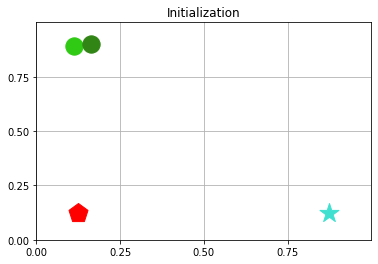

In [524]:
def plot_scatterplot(*args):

    # to print grid on map
    ax = plt.figure().gca()
    ax.set_xticks(np.arange(0, 1, 0.25))
    ax.set_yticks(np.arange(0, 1, 0.25))
    plt.grid()

    for i in Robotx._registry:
        # color gradient to better visualize the different robots within the map
        robot_color = hex(int("0x30ca15", 16) + int("0x00bb00", 16)*int(i.name[1])).replace("0x","#")
        plt.scatter(i.betax, i.betay, s = 300, marker = 'o', color = robot_color)
        
    plt.scatter(T.x, T.y, s = 400, marker = '*', color = 'turquoise')

    for o in Obstacle._registry:
        plt.scatter(o.x, o.y, s = 400, marker = 'p', color = 'red')

    plt.axis([0, 1, 0, 1])

    if args:
        plt.title(args[0])
        
    plt.show() 

plot_scatterplot("Initialization")

In [525]:
for r in Robotx._registry:
    if (r.delta < 0.5):
        print(f"{r.name} {r.delta:.2f} achtung!") # and start from this point to build the reshuffle section

R0 -0.08 achtung!
R1 -0.05 achtung!


In [526]:
# Centroid handling -------------------------------------------------------------------------

In [527]:
# returns a dict so that:
#  - the keys are the coordinates of the centroids of a square dim_map x dim_map map of side length 1
#  - the values are in the form (micro_cell, macro_cell) of the centroids
def find_centroids(dim_map):

    unit_displacement = 1 / (dim_map*2)

    centroids_coords = []
    for i in range(dim_map,0,-1):
        row = []
        for j in range(dim_map): 
            row.append((j*unit_displacement*2 + unit_displacement, i*unit_displacement*2 - unit_displacement))
        centroids_coords.append(row)

    centroids_dict = {t: (f"{str(i%2)}{str(j%2)}", f"{0 if t[1] > 0.5 else 1}{0 if t[0] < 0.5 else 1}")
     for i,row in enumerate(centroids_coords) for j,t in enumerate(row)}
     
    return centroids_dict

centroids = find_centroids(4)

print("Centroids:\n{ " + "\n  ".join(f"{k}: {v} " for k, v in centroids.items()) + "}")

Centroids:
{ (0.125, 0.875): ('00', '00') 
  (0.375, 0.875): ('01', '00') 
  (0.625, 0.875): ('00', '01') 
  (0.875, 0.875): ('01', '01') 
  (0.125, 0.625): ('10', '00') 
  (0.375, 0.625): ('11', '00') 
  (0.625, 0.625): ('10', '01') 
  (0.875, 0.625): ('11', '01') 
  (0.125, 0.375): ('00', '10') 
  (0.375, 0.375): ('01', '10') 
  (0.625, 0.375): ('00', '11') 
  (0.875, 0.375): ('01', '11') 
  (0.125, 0.125): ('10', '10') 
  (0.375, 0.125): ('11', '10') 
  (0.625, 0.125): ('10', '11') 
  (0.875, 0.125): ('11', '11') }


In [528]:
# returns the centroid tuple of the cell that a point of coordinates (x,y) is located in
def find_closest_centroid(centroids, x, y):
    centroids_coords = np.array(list(centroids.keys()))
    distances = np.linalg.norm(centroids_coords-np.array([x, y]), axis=1)
    return centroids[tuple(centroids_coords[np.argmin(distances)])]
    
for r in Robotx._registry:
    print(f"Closest centroid to {r.name}: {find_closest_centroid(centroids, r.betax, r.betay)}")

Closest centroid to R0: ('00', '00')
Closest centroid to R1: ('00', '00')


In [529]:
# associate centroids to obstacles
obstacles_centroids = {coord: v for (coord,v) in centroids.items() for o in Obstacle._registry if coord == (o.x, o.y)}
print("Obstacles' centroids:\n{ " + "\n  ".join(f"{k}: {v} " for k, v in obstacles_centroids.items()) + "}")

Obstacles' centroids:
{ (0.125, 0.125): ('10', '10') }


In [530]:
# Grover planner -------------------------------------------------------------------------    

In [531]:
# takes as input strings with the binary encoding of cells and outputs the manhattan distance between them
def manhattan(start_cell, target_cell):
    start_cell_v, target_cell_v = [int(b) for b in start_cell], [int(b) for b in target_cell]
    return int(cityblock(start_cell_v, target_cell_v).item())

In [532]:
class GroverPlanner:
    def __init__(self, obstacles):
        self.obstacles = obstacles

    #
    # Utility functions
    #
    def XOR(self, qc, a, b, output):
        qc.cx(a, output)
        qc.cx(b, output)

    def encode_cell(self, qc, cell, qubits):
        for idx, bit in enumerate(cell):
            bitn = int(bit)
            if bitn:
                qc.x(qubits[idx])

    def encode_target(self, qc, target_cell, qubits):
        for idx, bit in enumerate(target_cell):
            bitn = int(bit)
            if not bitn:
                qc.x(qubits[idx])

    def obstacles_in_map(self, target_cell):
        return any(target_cell[1] == macro_cell for macro_cell in list(map(lambda ob_t: ob_t[1], self.obstacles)))

    #
    # Grover diffuser
    #
    def diffuser(self, nqubits):
        diff = QuantumCircuit(nqubits)

        # Apply transformation |s> -> |00..0> (H-gates)
        for qubit in range(nqubits):
            diff.h(qubit)

        # Apply transformation |00..0> -> |11..1> (X-gates)
        for qubit in range(nqubits):
            diff.x(qubit)

        # Do multi-controlled-Z gate
        diff.h(nqubits - 1)
        diff.mct(list(range(nqubits - 1)), nqubits - 1)  # multi-controlled-toffoli
        diff.h(nqubits - 1)

        # Apply transformation |11..1> -> |00..0>
        for qubit in range(nqubits):
            diff.x(qubit)

        # Apply transformation |00..0> -> |s>
        for qubit in range(nqubits):
            diff.h(qubit)
        
        U_s = diff.to_gate()
        U_s.name = "U$_\psi$"
        return U_s

    #
    # Half oracle
    #
    # it performs the quantum moves to get to the final state the solution test is performed on; its structure 
    # changes according to both the number of movements required to get to the target and the presence of obstacles
    #
    def half_oracle(self, num_of_M, obstacles_in_map, quantum_registers):

        if num_of_M == 1:

            ho = QuantumCircuit(*quantum_registers)
            pos_qubits, mov_qubits, c, output = quantum_registers

            # -- First M --
            self.XOR(ho, pos_qubits[1], mov_qubits[0], c[0])
            ho.x(c[0])
            self.XOR(ho, pos_qubits[0], mov_qubits[0], c[1])

        elif num_of_M == 2:

            ho = QuantumCircuit(*quantum_registers)

            if obstacles_in_map:
                pos_qubits, mov_qubits, c, o, caux, out, output = quantum_registers
            else:
                pos_qubits, mov_qubits, c, output = quantum_registers

            # -- First M --
            self.XOR(ho, pos_qubits[1], mov_qubits[0], c[0])
            ho.x(c[0])
            self.XOR(ho, pos_qubits[0], mov_qubits[0], c[1])

            if obstacles_in_map:
                # -- Obstacle encoding --
                for obstacle in self.obstacles:
                    self.encode_cell(ho, obstacle[0], [c[0], c[1]])
                    ho.ccx(c[0], c[1], o)
                    self.encode_cell(ho, obstacle[0], [c[0], c[1]])

            # -- Second M --
            self.XOR(ho, c[1], mov_qubits[1], c[2])
            ho.x(c[2])
            self.XOR(ho, c[0], mov_qubits[1], c[3])

            if obstacles_in_map:
                # -- Selection stage --
                ho.ccx(c[2], o, caux[0])
                ho.x(caux[0])
                ho.ccx(c[3], o, caux[1])
                ho.x(caux[1])

                ho.x(o)

                ho.ccx(pos_qubits[0], o, caux[2])
                ho.x(caux[2])
                ho.ccx(pos_qubits[1], o, caux[3])
                ho.x(caux[3])

                ho.ccx(caux[0], caux[2], out[0])
                ho.x(out[0])
                ho.ccx(caux[1], caux[3], out[1])
                ho.x(out[1])

        HalfOracle = ho.to_gate()
        HalfOracle.name = "HO"
        return HalfOracle

    #
    # Grover oracle
    #
    # it is composed of a oracle half, the testing operator, and the mirror circuit of the first half
    #
    def oracle(self, num_of_M, target_cell, m_type, obstacles_in_map, qc, quantum_registers):

        halforacle = self.half_oracle(num_of_M, obstacles_in_map, quantum_registers)

        additional_regs = []

        if obstacles_in_map:
            pos_qubits, mov_qubits, c, *additional_regs, output = quantum_registers
        else:
            pos_qubits, mov_qubits, c, output = quantum_registers

        # -- First half of the oracle --
        qc.append(
            halforacle,
            pos_qubits[:]
            + mov_qubits[:]
            + c[:]
            + (
                (additional_regs[0][:] + additional_regs[1][:] + additional_regs[2][:])
                if additional_regs
                else []
            )
            + output[:],
        )

        # -- Test operator --
        test_qubits = c[-2:] if num_of_M == 1 or (num_of_M == 2 and not obstacles_in_map) else additional_regs[2]
        tcell_idx = 0 if m_type == "micro" else 1
        self.encode_target(qc, target_cell[tcell_idx], [test_qubits[0], test_qubits[1]])
        qc.ccx(test_qubits[0], test_qubits[1], output)
        self.encode_target(qc, target_cell[tcell_idx], [test_qubits[0], test_qubits[1]])

        # -- Mirror circuit of the first half of the oracle --
        qc.append(
            halforacle.inverse(),
            pos_qubits[:]
            + mov_qubits[:]
            + c[:]
            + (
                (additional_regs[0][:] + additional_regs[1][:] + additional_regs[2][:])
                if additional_regs
                else []
            )
            + output[:],
        )

    #
    # Path planning
    #
    # takes as input the tuples of centroids start_cell and target_cell, together with the movement type (m_type),
    # that can yield the values "micro" or "macro"
    #
    def find_path(self, start_cell, target_cell, m_type):

        # number of M operators is equal to the Manhattan distance between start and target
        cell_idx = 0 if m_type == "micro" else 1
        num_of_M = manhattan(start_cell[cell_idx], target_cell[cell_idx])

        # --- Initializations ---
        pos_qubits = QuantumRegister(2, name="r")
        mov_qubits = QuantumRegister(num_of_M, name="m")
        c = QuantumRegister(2 * num_of_M, name="c")

        o = QuantumRegister(1, name="o")
        caux = QuantumRegister(4, name="caux")
        out = QuantumRegister(2, name="out")

        output = QuantumRegister(1, name="q")
        cbits = ClassicalRegister(2 + num_of_M, name="cbits")

        # check if there are obstacles to be considered within the path
        obstacles_in_map = self.obstacles_in_map(target_cell) and m_type == "micro"

        # ensemble of quantum registers to build the QuantumCircuit with
        base_registers = [pos_qubits, mov_qubits, c, output, cbits]
        additional_registers = base_registers.copy()
        additional_registers[3:3] = [o, caux, out]
        quantum_registers = (
            base_registers
            if num_of_M == 1 or (num_of_M == 2 and not obstacles_in_map)
            else additional_registers
        )

        qc = QuantumCircuit(*quantum_registers)

        # initialize pos_qubits in uniform superposition
        qc.h(pos_qubits)

        # initialize mov_qubits in state |s>
        qc.h(mov_qubits)

        # initialize 'output0' in state |->
        qc.initialize([1, -1] / np.sqrt(2), output)

        # --- Oracle + Diffuser ---
        num_iterations = 1
        for _ in range(num_iterations):
            self.oracle(
                num_of_M,
                target_cell,
                m_type,
                obstacles_in_map,
                qc,
                quantum_registers[:-1],
            )
            diff_qubits = [0, 1, 2] if num_of_M == 1 else [0, 1, 2, 3]
            qc.append(self.diffuser(len(diff_qubits)), diff_qubits)

        # --- Measurement ---
        qc.measure(pos_qubits, cbits[0:2])
        qc.measure(mov_qubits, cbits[2 : (2 + num_of_M)])

        # --- Simulation ---
        aer_sim = Aer.get_backend("aer_simulator")
        transpiled_qc = transpile(qc, aer_sim)
        result_counts = aer_sim.run(transpiled_qc).result().get_counts()

        # filtering out all the non-trivial solutions on the simulation output
        return [k for k in result_counts.keys() if k[-2:] == start_cell[cell_idx][len(start_cell[cell_idx]) :: -1]]

groverPlanner = GroverPlanner(obstacles_centroids.values())

In [533]:
# test
groverPlanner.find_path(start_cell=("00", "10"), target_cell=("11", "10"), m_type="micro")

['1100']

In [534]:
# Reshuffling ----------------------------------------------------------------------------

In [535]:
# returns a list with the micro and macro displacement after the movement
def eval_displacement(old_centroid, new_centroid):
    old_c_micro, old_c_macro = old_centroid
    new_c_micro, new_c_macro = new_centroid
    return [manhattan(old_c_micro, new_c_micro), manhattan(old_c_macro, new_c_macro)]

In [536]:
# computes the movements required to get to the position encoded in new_alphas, which has the form [new_alphax, new_alphay]
#
# it also updates the new position of the robot, so there is no need to do that separately
#
def compute_path_to_position(robot, new_alphas):

    # starting centroid
    old_centroid = find_closest_centroid(centroids, robot.betax, robot.betay)

    # assign new positions
    robot.alphax, robot.alphay = new_alphas
    robot.betax, robot.betay = 1 - robot.alphax, 1 - robot.alphay

    # new centroid
    new_centroid = find_closest_centroid(centroids, robot.betax, robot.betay)

    # displacement between the new and starting centroids
    displacement = eval_displacement(old_centroid, new_centroid)

    #
    # Planning the path according to the different possible displacement:
    #   - macro: the robot changes macro-cell but stays in the same micro-cell
    #   - micro: the robot changes micro-cell but stays in the same macro-cell
    #   - macro and micro: the robot changes both macro and micro cells
    #   - if the new position is in the same micro and macro cells nothing happens
    # 

    # --- Macro movement ---
    if displacement[0] == 0 and displacement[1] != 0:
        print(f"{robot.name}: macro")
        evaluated_path = groverPlanner.find_path(old_centroid, new_centroid, m_type="macro")
        print(f"{robot.name} evaluated path: {evaluated_path[0][:-2]}")

    # --- Micro movement ---
    elif displacement[0] != 0 and displacement[1] == 0:
        print(f"{robot.name}: micro")
        evaluated_path = groverPlanner.find_path(old_centroid, new_centroid, m_type="micro")
        print(f"{robot.name} evaluated path: {evaluated_path[0][:-2]}")

    # --- Macro and micro movement ---
    elif displacement[0] != 0 and displacement[1] != 0:
        print(f"{robot.name}: macro-micro")
        # macro path
        evaluated_path = groverPlanner.find_path(old_centroid, new_centroid, m_type="macro")
        print(f"{robot.name} evaluated path (macro): {evaluated_path[0][:-2]}")
    
        # micro path
        evaluated_path = groverPlanner.find_path(old_centroid, new_centroid, m_type="micro")
        print(f"{robot.name} evaluated path (micro): {evaluated_path[0][:-2]}")
        

In [537]:
# check whether a given position ends up in a obstacle cell
def is_position_on_obstacle(new_alphas):
    new_pos_centroid = find_closest_centroid(centroids, 1-new_alphas[0], 1-new_alphas[1])
    return True if new_pos_centroid in obstacles_centroids.values() else False

In [538]:
result = all(i.delta < 0.8 for i in Robotx._registry)
print("Do all the robots have a reward lower than 0.8? : " + str(result))

# if True: reshuffle positions
# if False: do nothing

# reshuffling is considered invalid if the target position of the robot is the same as that of an obstacle;
# with this consideration, no computational time is wasted trying to find the path to an inaccessible cell

if result == True:
    for i in Robotx._registry:
        new_alphas = [np.random.uniform(0,0.9), np.random.uniform(0,0.9)]

        # if new position ends up in an obstacle cell, recompute the alphas
        while is_position_on_obstacle(new_alphas):
            new_alphas = [np.random.uniform(0,0.9), np.random.uniform(0,0.9)]

        compute_path_to_position(i, new_alphas)
               

Do all the robots have a reward lower than 0.8? : True
R0: macro-micro
R0 evaluated path (macro): 00
R0 evaluated path (micro): 0
R1: macro-micro
R1 evaluated path (macro): 0
R1 evaluated path (micro): 1


In [539]:
# recalculate the rewards
def recalculate_rewards():
    for i in Robotx._registry:
        i.delta = reward(T, i.betax, i.betay)
        i.gamma = 1 - i.delta
        print(f"{i.name} {i.delta:.2f}")

In [540]:
recalculate_rewards()

R0 0.79
R1 0.53


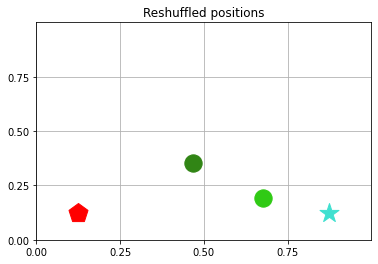

In [541]:
plot_scatterplot("Reshuffled positions")

In [542]:
# Quantum circuit construction ------------------------------------------------------------------

In [543]:
q = QuantumRegister(5, 'q') # qubits # changed to 9, formerly 15
m2 = ClassicalRegister(1, 'c1') # classical bits (separated is better)
m3 = ClassicalRegister(1, 'c2')
m4 = ClassicalRegister(1, 'c3')

qc3 = QuantumCircuit(q, m2, m3, m4) # to reach the target
qc4 = QuantumCircuit(q, m2, m3, m4) # to get back to the nest

In [544]:
# Which robot should enter the gate? -----------------------------------------------------------

In [545]:
def print_formatted_vector(*args):
    for vector in args:
        print("[" + "".join(f"{val:.2f} " for val in vector).strip() + "]")

In [546]:
# in case of ties on delta score, the max() function outputs the first maximum item it processes 
closest_robot = max(Robotx._registry, key=attrgetter('delta'))
print(f"Closest robot to the target: {closest_robot.name} {closest_robot.betax:.2f} {closest_robot.betay:.2f} {closest_robot.delta:.2f}")

# and then it enters the gate
vector0 = [closest_robot.alphax, closest_robot.betax]
vector1 = [closest_robot.alphay, closest_robot.betay]
vector3 = [closest_robot.gamma, closest_robot.delta]

normalized_v0 = vector0/np.linalg.norm(vector0)
normalized_v1 = vector1/np.linalg.norm(vector1)
normalized_v3 = vector3/np.linalg.norm(vector3)

print_formatted_vector(vector0, vector1, vector3)
print_formatted_vector(normalized_v0, normalized_v1, normalized_v3)

Closest robot to the target: R0 0.68 0.19 0.79
[0.32 0.68]
[0.81 0.19]
[0.21 0.79]
[0.43 0.90]
[0.97 0.23]
[0.26 0.97]


In [547]:
# Setting up |q_0> ------------------------------------------------------------------------------

In [548]:
# direct initialization with amplitudes vector
qc3.initialize(normalized_v0, q[0])
qc3.initialize(normalized_v1, q[1])
qc3.initialize(normalized_v3, q[2])

In [549]:
# this is the core code, and it is unchanged across time

qc3.barrier(q)
qc3.ccx(q[0],q[1],q[3])
qc3.ccx(q[0],q[1],q[4])

qc3.reset(q[3])
qc3.reset(q[4])

qc3.ccx(q[0],q[2],q[3]) 
qc3.ccx(q[1],q[2],q[4])

qc3.x(q[2])

qc3.ch(q[2],q[3])
qc3.ch(q[2],q[4])

qc3.x(q[2])

qc3.barrier(q)

# perform measurements and store them in classical bits

qc3.measure(q[2],m2[0])
qc3.measure(q[3],m3[0])
qc3.measure(q[4],m4[0])

# visualization of the ciruit

print(qc3)

      ┌─────────────────────────────┐ ░                                    »
 q_0: ┤ Initialize(0.43139,0.90216) ├─░───■────■─────────■─────────────────»
      ├─────────────────────────────┤ ░   │    │         │                 »
 q_1: ┤ Initialize(0.97212,0.23449) ├─░───■────■─────────┼────■────────────»
      ├─────────────────────────────┤ ░   │    │         │    │  ┌───┐     »
 q_2: ┤ Initialize(0.25727,0.96634) ├─░───┼────┼─────────■────■──┤ X ├──■──»
      └─────────────────────────────┘ ░ ┌─┴─┐  │       ┌─┴─┐  │  └───┘┌─┴─┐»
 q_3: ────────────────────────────────░─┤ X ├──┼───|0>─┤ X ├──┼───────┤ H ├»
                                      ░ └───┘┌─┴─┐     └───┘┌─┴─┐     └───┘»
 q_4: ────────────────────────────────░──────┤ X ├─|0>──────┤ X ├──────────»
                                      ░      └───┘          └───┘          »
c1: 1/═════════════════════════════════════════════════════════════════════»
                                                                           »

counts:  {'0 1 1': 760, '0 0 1': 150, '1 1 1': 35, '0 0 0': 13, '0 1 0': 17, '1 0 0': 20, '1 1 0': 20, '1 0 1': 9}


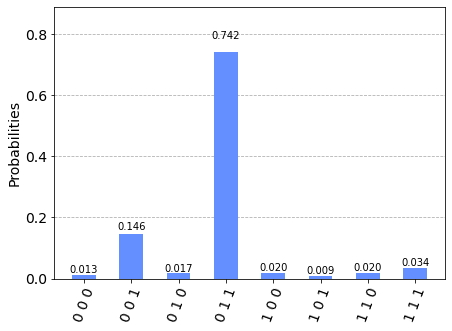

In [550]:
# --- Simulation ---
aer_sim = Aer.get_backend("aer_simulator")
transpiled_qc = transpile(qc3, aer_sim)
result = aer_sim.run(transpiled_qc).result()

counts = result.get_counts()
print("counts: ", counts)

plot_histogram(result.get_counts())

In [551]:
# calculate weighted outcome on the most probables outcomes of the circuit
def eval_outcome(most_prob_dict, n_outcome):
    mapped_weights = list(map(lambda res: int(res[n_outcome*2])*most_prob_dict[res], most_prob_dict))
    return sum(mapped_weights)/sum(most_prob_dict.values())

In [552]:
num_most_prob_states = 4

# extract the most probable states and then evaluate the outcome
most_prob_dict = dict(heapq.nlargest(num_most_prob_states, counts.items(), key=itemgetter(1)))
print(f"{num_most_prob_states} most probable states: {most_prob_dict}")

outcome0, outcome1 = eval_outcome(most_prob_dict, 0), eval_outcome(most_prob_dict, 1)

print(f"outcome0: {outcome0:.2f}\noutcome1: {outcome1:.2f}")

4 most probable states: {'0 1 1': 760, '0 0 1': 150, '1 1 1': 35, '1 0 0': 20}
outcome0: 0.06
outcome1: 0.82


In [553]:
# Setting new positions after the gate ---------------------------------------------------------------

In [554]:
for i in Robotx._registry:
    print(f"{i.name} {i.betax:.2f} {i.betay:.2f}")
    if (i.delta != closest_robot.delta or all(i.delta == j.delta for j in Robotx._registry)): # excluding the robot that entered the gate
        # CHANGE: but taking into account the case where all robots have the same reward!!!
        # for z
        #i.betaz = outcome0
        # the lower this value, the closer the robot to the 0, the higher alphaz
        #i.alphaz = round(1 - i.betaz, 3)

        compute_path_to_position(i, [1-outcome1, 1-outcome0]) # update on alphas is done within the function

R0 0.68 0.19
R1 0.47 0.36
R1: macro-micro
R1 evaluated path (macro): 0
R1 evaluated path (micro): 1


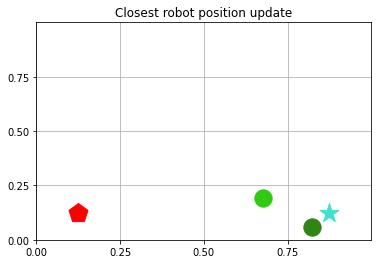

In [555]:
plot_scatterplot("Closest robot position update")

In [556]:
# former rewards 
for i in  Robotx._registry:
    print(f"before the gate: {i.name} {i.delta:.2f}")

before the gate: R0 0.79
before the gate: R1 0.53


In [557]:
# new rewards
print("Rewards after the gate: ")
recalculate_rewards()

Rewards after the gate: 
R0 0.79
R1 0.91


In [558]:
# Reach the most successful robot -------------------------------------------------------

In [559]:
# parse the most successful robot
max_attr_ = max(Robotx._registry, key=attrgetter('delta'))
print(f"max_attr_.delta: {max_attr_.delta:.2f}")

for i in Robotx._registry:
    if (i.delta == max_attr_.delta):
        print(f"Most successful robot: {i.name} {i.betax:.2f} {i.betay:.2f} {i.delta:.2f}") # and then it enters the gate

for j in Robotx._registry:
    # to get other robots following it:
    if (j != max_attr_): 
        compute_path_to_position(j, [max_attr_.alphax + np.random.uniform(0,0.03), max_attr_.alphay + np.random.uniform(0,0.03)])
                   

max_attr_.delta: 0.91
Most successful robot: R1 0.82 0.06 0.91
R0: micro
R0 evaluated path: 0


In [560]:
recalculate_rewards()

R0 0.90
R1 0.91


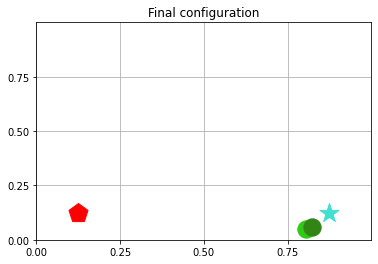

In [561]:
plot_scatterplot("Final configuration")